# Sentiment Analysis

In [121]:
import pandas as pd

df = pd.read_csv("YoutubeCommentsDataSet.csv")
df.head()

,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive


In [122]:
df.shape

(18408, 2)

We can see that they are 18000 comments

In [123]:
df.isnull().sum()

Comment      44
Sentiment     0
dtype: int64

In [124]:
df=df.dropna()

We delete the lines that are empty

In [125]:
print(df["Comment"][3])

whenever i go to a place that doesn’t take apple pay doesn’t happen too often it’s such a drag between ‘contactless covid’ habits and my getting the apple card i’ve gotten so used to apple pay that i get seriously annoyed when a store doesn’t take it it feels like a shock it’s crazy how quickly it took over my shopping routine i’ve officially been brainwashed by apple because now it feels so inconvenient to even carry a physical card in my pocket


In [126]:
df['Sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

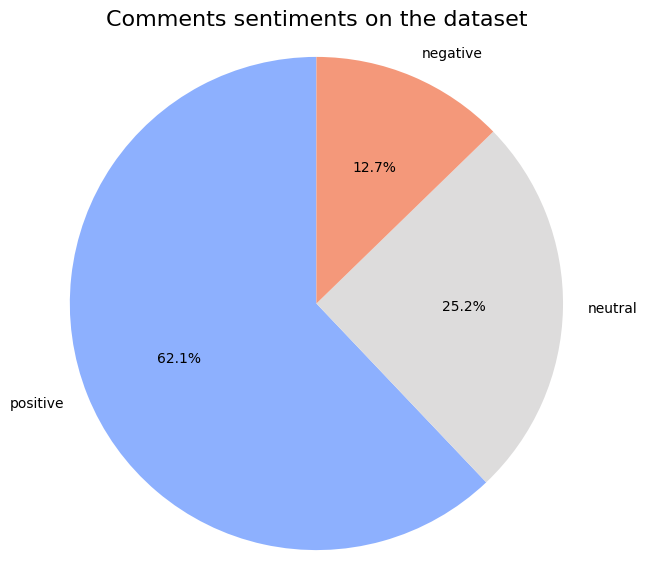

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns

sentiment_counts = df['Sentiment'].value_counts()

plt.figure(figsize=(7,7))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('coolwarm', 3))
plt.title("Comments sentiments on the dataset", fontsize=16)
plt.axis('equal')
plt.show()


We can see their a huge imbalence in the dataset

In [96]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import emoji

# --- settings NLTK ---
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# --- clean text ---
def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = emoji.demojize(text)
    text = re.sub(r'\s+', ' ', text).strip()
    # delete stopwords et lemmatize
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

# --- preprocessing ---
df['cleaned_text'] = df['Comment'].apply(clean_text)

label_map = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
}
df['Sentiment'] = df['Sentiment'].map(label_map)

# --- target and features ---
X = df['cleaned_text']          # features
y = df['Sentiment']    # target : Positive / Negative / Neutral

# --- Train/Test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      # 20% for test      
    random_state=42
)

# --- vectorization TF-IDF ---
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# --- verification of dimensions ---
print("X_train:", X_train_tfidf.shape)
print("X_test :", X_test_tfidf.shape)
print("y_train distribution:\n", y_train.value_counts())
print("y_test distribution:\n", y_test.value_counts())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


X_train: (14691, 5000)
X_test : (3673, 5000)
y_train distribution:
 Sentiment
2    9082
1    3713
0    1896
Name: count, dtype: int64
y_test distribution:
 Sentiment
2    2320
1     912
0     441
Name: count, dtype: int64


Here we do the pre processing:
- Delete numbers, dots, hashtags
- Split the sentence in words
- Withdraw the stopwords(words that does'nt have a lot of importance)
- Lemmatize the words
- Vectorize the words


# Testing models

Logistic regression avec smote

In [97]:
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)
logistic = LogisticRegression(max_iter=1000, class_weight='balanced')
logistic.fit(X_train_smote, y_train_smote)
print(y_train_smote.value_counts())

Sentiment
2    9082
0    9082
1    9082
Name: count, dtype: int64


Accuracy 0.7331881295943371


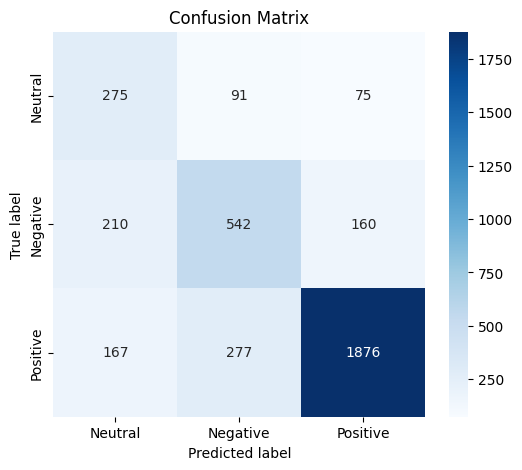

              precision    recall  f1-score   support

     Neutral       0.42      0.62      0.50       441
    Negative       0.60      0.59      0.59       912
    Positive       0.89      0.81      0.85      2320

    accuracy                           0.73      3673
   macro avg       0.64      0.68      0.65      3673
weighted avg       0.76      0.73      0.74      3673



In [98]:
y_predict=logistic.predict(X_test_tfidf)
from sklearn.metrics import accuracy_score

print("Accuracy",accuracy_score(y_test, y_predict))

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_predict)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neutral', 'Negative', 'Positive'], yticklabels=['Neutral', 'Negative', 'Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import classification_report
print(classification_report(y_test, y_predict, target_names=['Neutral', 'Negative', 'Positive']))

Without Smote it is less good

**Naive_bayes**

In [99]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)

MultinomialNB()

Accuracy 0.6964334331609039


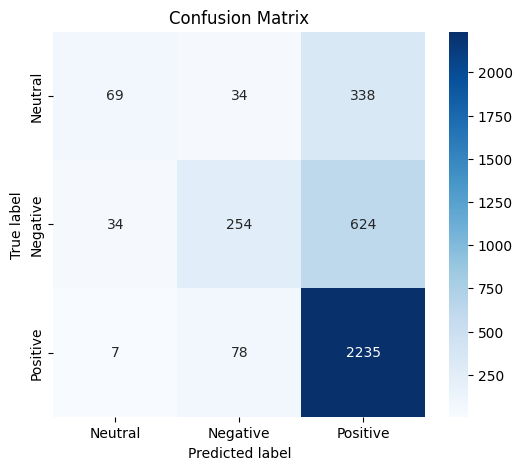

              precision    recall  f1-score   support

     Neutral       0.63      0.16      0.25       441
    Negative       0.69      0.28      0.40       912
    Positive       0.70      0.96      0.81      2320

    accuracy                           0.70      3673
   macro avg       0.67      0.47      0.49      3673
weighted avg       0.69      0.70      0.64      3673



In [100]:
y_predict=nb.predict(X_test_tfidf)
from sklearn.metrics import accuracy_score
print("Accuracy",accuracy_score(y_test, y_predict))

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_predict)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neutral', 'Negative', 'Positive'], yticklabels=['Neutral', 'Negative', 'Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import classification_report
print(classification_report(y_test, y_predict, target_names=['Neutral', 'Negative', 'Positive']))


Random Forest

In [101]:
#pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1

In [102]:
type(X_train_tfidf)

scipy.sparse._csr.csr_matrix

In [103]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)

Accuracy 0.7312823305200109


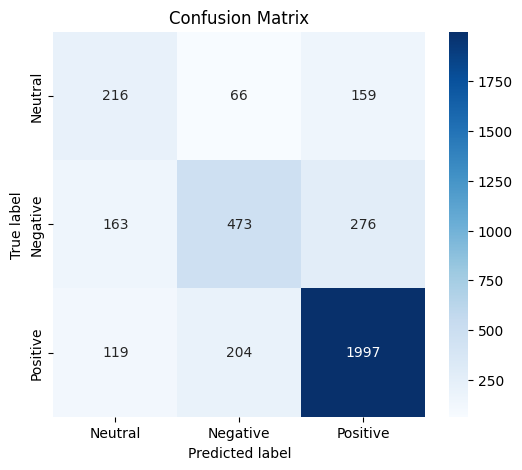

              precision    recall  f1-score   support

     Neutral       0.43      0.49      0.46       441
    Negative       0.64      0.52      0.57       912
    Positive       0.82      0.86      0.84      2320

    accuracy                           0.73      3673
   macro avg       0.63      0.62      0.62      3673
weighted avg       0.73      0.73      0.73      3673



In [104]:
from sklearn.ensemble import RandomForestClassifier
randomforest = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
randomforest.fit(X_train_smote, y_train_smote)
y_predict=randomforest.predict(X_test_tfidf)

from sklearn.metrics import accuracy_score
print("Accuracy",accuracy_score(y_test, y_predict))

from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_test, y_predict)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neutral', 'Negative', 'Positive'], yticklabels=['Neutral', 'Negative', 'Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import classification_report
print(classification_report(y_test, y_predict, target_names=['Neutral', 'Negative', 'Positive']))

Without Smote

In [105]:
randomforest.fit(X_train_tfidf, y_train)
y_predict=randomforest.predict(X_test_tfidf)
print("Accuracy",accuracy_score(y_test, y_predict))
confusion_matrix(y_test, y_predict)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_predict, target_names=['Neutral', 'Negative', 'Positive']))

Accuracy 0.744078410019058
              precision    recall  f1-score   support

     Neutral       0.56      0.29      0.38       441
    Negative       0.64      0.57      0.60       912
    Positive       0.79      0.90      0.84      2320

    accuracy                           0.74      3673
   macro avg       0.66      0.59      0.61      3673
weighted avg       0.73      0.74      0.73      3673



Xgboost

C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:199: UserWarning: [15:13:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.7476177511570923
              precision    recall  f1-score   support

     Neutral       0.62      0.30      0.41       441
    Negative       0.60      0.63      0.61       912
    Positive       0.81      0.88      0.85      2320

    accuracy                           0.75      3673
   macro avg       0.68      0.60      0.62      3673
weighted avg       0.74      0.75      0.74      3673



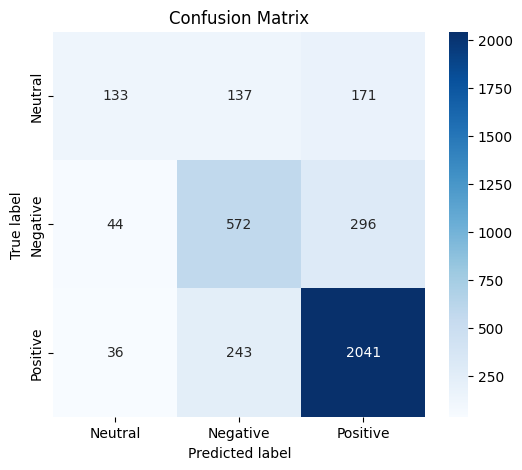

In [106]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- training of the model XGBoost ---
xgb = XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', use_label_encoder=False, random_state=42)
xgb.fit(X_train_tfidf, y_train)

# --- predictions ---
y_pred = xgb.predict(X_test_tfidf)

# --- accuracy ---
print("Accuracy:", accuracy_score(y_test, y_pred))

# --- classification report ---
print(classification_report(y_test, y_pred, target_names=['Neutral', 'Negative', 'Positive']))

# --- confusion matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neutral', 'Negative', 'Positive'], yticklabels=['Neutral', 'Negative', 'Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

Transformer Distil bert

In [107]:
def clean_text_bert(text):
    if pd.isna(text):
        return ""
    text = str(text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    text = emoji.demojize(text)
    text = re.sub(r'[^\w\s:]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [108]:
df = pd.read_csv("YoutubeCommentsDataSet.csv")  

df.head()

,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive


In [109]:
df = df.dropna()
df = df.drop_duplicates()
df['Comment'] = df['Comment'].str.strip()

In [110]:
label_map = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
}
df['label'] = df['Sentiment'].map(label_map)

In [111]:
df = df.rename(columns={'Comment': 'text'})

df = df[['text', 'label']]

In [112]:
df.head()

,text,label
0,lets not forget that apple pay in 2014 require...,1
1,here in nz 50 of retailers don’t even have con...,0
2,i will forever acknowledge this channel with t...,2
3,whenever i go to a place that doesn’t take app...,0
4,apple pay is so convenient secure and easy to ...,2


In [113]:
df.shape

(17874, 2)

In [114]:
import pandas as pd
from datasets import Dataset
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
import numpy as np

# --- split train/test ---
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# --- conversion for HuggingFace dataset ---
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
train_dataset = train_dataset.shuffle(seed=42).select(range(7000))
test_dataset = test_dataset.shuffle(seed=42).select(range(1000))

# --- tokenization ---
model_checkpoint = "prajjwal1/bert-tiny"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_fn(example):
     return tokenizer(
        example["text"],
        truncation=True,
        max_length=512,
        padding="max_length"
    )

train_dataset = train_dataset.map(tokenize_fn, batched=True)
test_dataset = test_dataset.map(tokenize_fn, batched=True)

# --- preparing the model ---
num_labels = len(label_map)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# --- metrics --
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy.compute(predictions=predictions, references=labels)
    f1_score = f1.compute(predictions=predictions, references=labels, average="weighted")
    return {"accuracy": acc["accuracy"], "f1": f1_score["f1"]}

# --- training ---
training_args = TrainingArguments(
    output_dir="./sentiment_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    load_best_model_at_end=True,
    fp16=False,
    fp16_full_eval=False,
    save_safetensors=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

# --- save the model ---
trainer.save_model("./sentiment_model")
tokenizer.save_pretrained("./sentiment_model")

print("Fine-tuning finished & model saved in ./sentiment_model")


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Map: 100%|██████████| 1000/1000 [00:00<00:00, 4892.87 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformer

{'eval_loss': 0.813371479511261, 'eval_accuracy': 0.675, 'eval_f1': 0.5936620892108273, 'eval_runtime': 7.7688, 'eval_samples_per_second': 128.72, 'eval_steps_per_second': 8.109, 'epoch': 1.0}



 52%|█████▏    | 459/876 [12:22<01:37,  4.29it/s]

{'loss': 0.872, 'grad_norm': 2.6891682147979736, 'learning_rate': 8.584474885844748e-06, 'epoch': 1.14}


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)






































                                         
                                                 
 52%|█████▏    | 459/876 [16:06<01:37,  4.29it/s]

100%|██████████| 876/876 [06:19<00:00,  2.31it/s]

{'eval_loss': 0.7780373692512512, 'eval_accuracy': 0.683, 'eval_f1': 0.6070726189378147, 'eval_runtime': 6.3928, 'eval_samples_per_second': 156.425, 'eval_steps_per_second': 9.855, 'epoch': 2.0}
{'train_runtime': 379.9325, 'train_samples_per_second': 36.849, 'train_steps_per_second': 2.306, 'train_loss': 0.8431300681475635, 'epoch': 2.0}
Fine-tuning finished & model saved in ./sentiment_model


In [115]:
# --- evaluate ---
results = trainer.evaluate(test_dataset)
print(results)

C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 63/63 [00:08<00:00,  7.27it/s]

{'eval_loss': 0.7780373692512512, 'eval_accuracy': 0.683, 'eval_f1': 0.6070726189378147, 'eval_runtime': 8.778, 'eval_samples_per_second': 113.921, 'eval_steps_per_second': 7.177, 'epoch': 2.0}


In [116]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline

finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer)

sentences = ["Digusting i hate it"]
results = nlp(sentences)
print(results)  #LABEL_0: neutral; LABEL_1: positive; LABEL_2: negative


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


[{'label': 'Neutral', 'score': 0.9396127462387085}]


In [117]:
from transformers import pipeline

# Load the classification pipeline with the specified model
pipe = pipeline("text-classification", model="tabularisai/multilingual-sentiment-analysis")

# Classify a new sentence
sentence = "I love this product! It's amazing and works perfectly."
result = pipe(sentence)

# Print the result
print(result)


[{'label': 'Very Positive', 'score': 0.5586307048797607}]


LSTM

In [118]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# --- settings ---
max_words = 5000
max_len = 100

# --- tokenisation ---
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# --- encoding des labels ---
y_train_cat = to_categorical(y_train, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

# --- model LSTM ---
model = Sequential()
model.add(Embedding(max_words, 128, input_length=max_len))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# --- training ---
history = model.fit(X_train_pad, y_train_cat, epochs=7, batch_size=64, validation_data=(X_test_pad, y_test_cat))

# --- evaluate ---
score = model.evaluate(X_test_pad, y_test_cat, verbose=0)
print("Test accuracy:", score[1])

Epoch 1/7


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


230/230 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.6852 - loss: 0.7240 - val_accuracy: 0.7354 - val_loss: 0.6235
Epoch 2/7
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7916 - loss: 0.5010 - val_accuracy: 0.7506 - val_loss: 0.6037
Epoch 3/7
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.8404 - loss: 0.4036 - val_accuracy: 0.7503 - val_loss: 0.6555
Epoch 4/7
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.8724 - loss: 0.3383 - val_accuracy: 0.7476 - val_loss: 0.7171
Epoch 5/7
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.8893 - loss: 0.2922 - val_accuracy: 0.7381 - val_loss: 0.8042
Epoch 6/7
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9083 - loss: 0.2498 - val_accuracy: 0.7419 - val_loss: 0.8547
Epoch 7/7
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9208 - loss: 0.2166 - val_accuracy: 0.7356 - val_loss: 0.9221
Test accuracy: 0.735638439655304


We can see that at epoch 2 our accuracy is at our peak and after it goes down. So we will choose to do 3 epochs.

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
              precision    recall  f1-score   support

     Neutral       0.49      0.46      0.48       441
    Negative       0.59      0.51      0.55       912
    Positive       0.82      0.88      0.85      2320

    accuracy                           0.74      3673
   macro avg       0.63      0.62      0.62      3673
weighted avg       0.73      0.74      0.73      3673



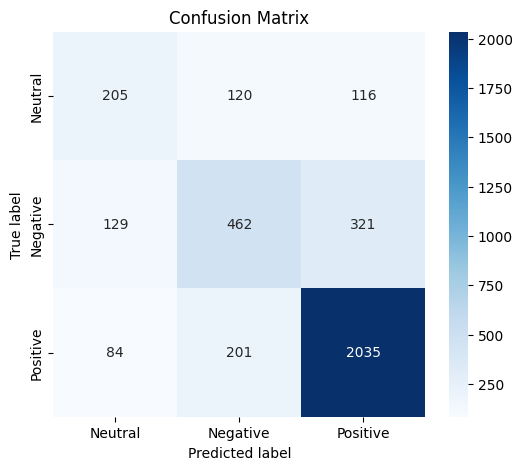

In [119]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -- predictions ---
y_pred_prob = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_prob, axis=1)

# --- classification report ---
print(classification_report(y_test, y_pred, target_names=['Neutral', 'Negative', 'Positive']))

# --- confusion matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neutral', 'Negative', 'Positive'], yticklabels=['Neutral', 'Negative', 'Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

END